In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
import requests, json
from typing import List, Dict

# Stock Prices EDA

## Compute Sharp Ratio

Risk-free rate is ~ $0.08$ for 2021

$s_a=\frac{E[R_a - R_b]}{\sigma_a}$


In [39]:
class SmigStock:

    DATE_FORMAT = "%Y-%m-%d"
    RISK_FREE_RATE = 0.0006

    @property
    def tickers(self):
        return self._tickers

    @tickers.setter
    def tickers(self, tickers: List[str]):
        if tickers and isinstance(tickers, list):
            self._tickers = tickers

    def add_ticker(self, ticker: str) -> None:
        self.tickers.append(ticker)

    @property
    def start_date(self) -> "datetime.datetime":
        return self._start_date

    @start_date.setter
    def start_date(self, value: str) -> None:
        if not isinstance(value, str):
            return
        try:
            self._start_date = datetime.datetime.strptime(value, SmigStock.DATE_FORMAT)
        except Exception as e:
            print(str(e))
            raise

    @property
    def end_date(self) -> "datetime.datetime":
        return self._end_date

    @end_date.setter
    def end_date(self, value: str) -> None:
        if not isinstance(value, str):
            return
        try:
            self._end_date = datetime.datetime.strptime(value, SmigStock.DATE_FORMAT)
        except Exception as e:
            print(str(e))
            raise

    def __init__(self, tickers: List[str], start_date: str, end_date: str) -> None:
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = {}

    def get_stocktwits_tickers(self):
        url = 'https://api.stocktwits.com/api/2/streams/trending.json'
        body = requests.get(url).json().get('messages')
        symbols = []
        for x in body:
            for _s in x.get('symbols'):
                symbol = _s.get('symbol')
                if isinstance(symbol, str) and '.X' not in symbol:
                    self.tickers.append(symbol)

    def _download_data(self, ticker):
        try:
            df = web.DataReader(ticker, 'yahoo', self.start_date, self.end_date)
        except:
            print(f"Error getting data for {ticker}")
        else:
            df.reset_index(inplace=True)
            df = df[['Date', 'Adj Close']]
            df.columns = ['ds', 'y']
            df.set_index('ds', inplace=True)
            return df

    def get_prices(self) -> None:
        #? Should you redownload price data for all tickers or just ones not already in self.data?
        for ticker in self.tickers:
            self.data[ticker] = {}
            if ticker in self.data:
                print(f"{ticker} data has already been downloaded")
                # continue
            print(f"Downloading stock price data for {ticker}")
            try:
                df = self._download_data(ticker)
            except:
                continue
            else:            
                df = self.compute_metrics(df)
                print("Download complete")
                self.data[ticker]['prices'] = df
                self.data[ticker]['sharp_ratio'] = self.compute_sharp_ratio(ticker)

    def compute_metrics(self, df):
        df['daily_ret'] = df.diff(axis=0)
        df['daily_percent'] = df['daily_ret'] / df['y'].shift()
        df['excess'] = df.daily_percent-SmigStock.RISK_FREE_RATE
        return df
        
    def compute_sharp_ratio(self, ticker):
        # grab the data
        df = self.data[ticker]['prices']
        s = (df.shape[0]/np.sqrt(252))*df.daily_percent.mean()/df.daily_percent.std()
        print("Sharp Ratio for %s = %s" % (ticker, s))
        return s

In [40]:
tickers = ['TSLA','AAPL','AMZN','NEO','MVIS']
ss = SmigStock(tickers=tickers,start_date='2020-10-01', end_date='2021-02-12')
ss.get_stocktwits_tickers()
ss.get_prices()

TSLA data has already been downloaded
Download complete
Sharp Ratio for TSLA = 1.1582631251741264
AAPL data has already been downloaded
Download complete
Sharp Ratio for AAPL = 0.5131143920651774
AMZN data has already been downloaded
Download complete
Sharp Ratio for AMZN = 0.11308695485187312
NEO data has already been downloaded
Download complete
Sharp Ratio for NEO = 1.3125240171466168
MVIS data has already been downloaded
Download complete
Sharp Ratio for MVIS = 1.537672911477813
VLDR data has already been downloaded
Download complete
Sharp Ratio for VLDR = 0.5094504260772551
ARBKF data has already been downloaded
Download complete
Sharp Ratio for ARBKF = 0.3622317225233833
VRUS data has already been downloaded
Download complete
Sharp Ratio for VRUS = 0.17132861350885056
SOAC data has already been downloaded
Download complete
Sharp Ratio for SOAC = 0.5783594165873307
AACQ data has already been downloaded
Download complete
Sharp Ratio for AACQ = 0.9076857869018919
VLDR data has alrea

<AxesSubplot:xlabel='ds'>

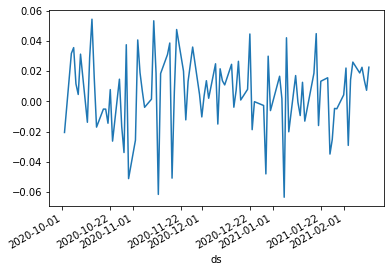

In [34]:
ss.data['NEO']['prices']['daily_percent'].plot()